In [1]:
import mxnet as mx
import matplotlib.pyplot as plt
import os.path as osp
import mxnet.image as image
from mxnet import gluon
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior
from mxnet.gluon import nn

D:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# setp 1
n = 40
# shape: batch x channel x height x weight
x = nd.random_uniform(shape=(1, 3, n, n))
y = MultiBoxPrior(x, sizes=[.5, .25, .1], ratios=[1, 2, .5])
# the first anchor box generated for pixel at (20,20)
# its format is (x_min, y_min, x_max, y_max)
boxes = y.reshape((n, n, -1, 4))
print('The first anchor box at row 21, column 21:', boxes[20, 20, 0, :])

The first anchor box at row 21, column 21: 
[0.2625 0.2625 0.7625 0.7625]
<NDArray 4 @cpu(0)>


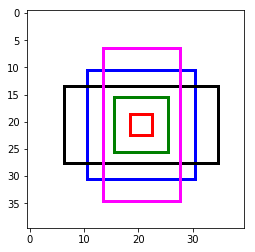

In [3]:
# setp 2
def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), (box[2]-box[0]), (box[3]-box[1]),
        fill=False, edgecolor=color, linewidth=linewidth)

colors = ['blue', 'green', 'red', 'black', 'magenta']
plt.imshow(nd.ones((n, n, 3)).asnumpy())
anchors = boxes[20, 20, :, :]
for i in range(anchors.shape[0]):
    plt.gca().add_patch(box_to_rect(anchors[i,:]*n, colors[i]))
plt.show()

In [4]:
# setp 3
def class_predictor(num_anchors, num_classes):
    """return a layer to predict classes"""
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)
cls_pred = class_predictor(5, 10)
cls_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
print('Class prediction', cls_pred(x).shape)

Class prediction (2, 55, 20, 20)


In [5]:
# setp 4
def box_predictor(num_anchors):
    """return a layer to predict delta locations"""
    return nn.Conv2D(num_anchors * 4, 3, padding=1)
box_pred = box_predictor(10)
box_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
print('Box prediction', box_pred(x).shape)

Box prediction (2, 40, 20, 20)


In [6]:
# setp 5
def down_sample(num_filters):
    """stack two Conv-BatchNorm-Relu blocks and then a pooling layer
    to halve the feature size"""
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out
blk = down_sample(10)
blk.initialize()
x = nd.zeros((2, 3, 20, 20))
print('Before', x.shape, 'after', blk(x).shape)

Before (2, 3, 20, 20) after (2, 10, 10, 10)


In [7]:
#setp 6
# a certain feature map with 20x20 spatial shape
feat1 = nd.zeros((2, 8, 20, 20))
print('Feature map 1', feat1.shape)
cls_pred1 = class_predictor(5, 10)
cls_pred1.initialize()
y1 = cls_pred1(feat1)
print('Class prediction for feature map 1', y1.shape)
# down-sample
ds = down_sample(16)
ds.initialize()
feat2 = ds(feat1)
print('Feature map 2', feat2.shape)
cls_pred2 = class_predictor(3, 10)
cls_pred2.initialize()
y2 = cls_pred2(feat2)
print('Class prediction for feature map 2', y2.shape)

Feature map 1 (2, 8, 20, 20)
Class prediction for feature map 1 (2, 55, 20, 20)
Feature map 2 (2, 16, 10, 10)
Class prediction for feature map 2 (2, 33, 10, 10)


In [8]:
# setp 7
def flatten_prediction(pred):
    return nd.flatten(nd.transpose(pred, axes=(0, 2, 3, 1)))
def concat_predictions(preds):
    return nd.concat(*preds, dim=1)
flat_y1 = flatten_prediction(y1)
print('Flatten class prediction 1', flat_y1.shape)
flat_y2 = flatten_prediction(y2)
print('Flatten class prediction 2', flat_y2.shape)
print('Concat class predictions', concat_predictions([flat_y1, flat_y2]).shape)

Flatten class prediction 1 (2, 22000)
Flatten class prediction 2 (2, 3300)
Concat class predictions (2, 25300)


In [9]:
# setp 8
def body():
    """return the body network"""
    out = nn.HybridSequential()
    for nfilters in [16, 32, 64]:
        out.add(down_sample(nfilters))
    return out
bnet = body()
bnet.initialize()
x = nd.zeros((2, 3, 256, 256))
print('Body network', [y.shape for y in bnet(x)])

Body network [(64, 32, 32), (64, 32, 32)]


In [10]:
# setp 9
def toy_ssd_model(num_anchors, num_classes):
    """return SSD modules"""
    downsamples = nn.Sequential()
    class_preds = nn.Sequential()
    box_preds = nn.Sequential()
    downsamples.add(down_sample(128))
    downsamples.add(down_sample(128))
    downsamples.add(down_sample(128))
    for scale in range(5):
        class_preds.add(class_predictor(num_anchors, num_classes))
        box_preds.add(box_predictor(num_anchors))
    return body(), downsamples, class_preds, box_preds
print(toy_ssd_model(5, 2))

(HybridSequential(
  (0): HybridSequential(
    (0): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=16)
    (2): Activation(relu)
    (3): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=16)
    (5): Activation(relu)
    (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  )
  (1): HybridSequential(
    (0): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
    (2): Activation(relu)
    (3): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
    (5): Activati

In [11]:
# setp 10
def toy_ssd_forward(x, body, downsamples, class_preds, box_preds, sizes, ratios):
    # extract feature with the body network
    x = body(x)
    # for each scale, add anchors, box and class predictions,
    # then compute the input to next scale
    default_anchors = []
    predicted_boxes = []
    predicted_classes = []
    for i in range(5):
        default_anchors.append(MultiBoxPrior(x, sizes=sizes[i], ratios=ratios[i]))
        predicted_boxes.append(flatten_prediction(box_preds[i](x)))
        predicted_classes.append(flatten_prediction(class_preds[i](x)))
        if i < 3:
            x = downsamples[i](x)
        elif i == 3:
            # simply use the pooling layer
            x = nd.Pooling(x, global_pool=True, pool_type='max', kernel=(4, 4))
    return default_anchors, predicted_classes, predicted_boxes

In [12]:
# setp 11
class ToySSD(gluon.Block):
    def __init__(self, num_classes, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # anchor box sizes for 4 feature scales
        self.anchor_sizes = [[.2, .272], [.37, .447], [.54, .619], [.71, .79], [.88, .961]]
        # anchor box ratios for 4 feature scales
        self.anchor_ratios = [[1, 2, .5]] * 5
        self.num_classes = num_classes
        with self.name_scope():
            self.body, self.downsamples, self.class_preds, self.box_preds = toy_ssd_model(4, num_classes)
    def forward(self, x):
        default_anchors, predicted_classes, predicted_boxes = toy_ssd_forward(x, self.body, self.downsamples,
            self.class_preds, self.box_preds, self.anchor_sizes, self.anchor_ratios)
        # we want to concatenate anchors, class predictions, box predictions from different layers
        anchors = concat_predictions(default_anchors)
        box_preds = concat_predictions(predicted_boxes)
        class_preds = concat_predictions(predicted_classes)
        # it is better to have class predictions reshaped for softmax computation
        class_preds = nd.reshape(class_preds, shape=(0, -1, self.num_classes + 1))

        return anchors, class_preds, box_preds

In [13]:
# setp 12
net = ToySSD(2)
net.initialize()
x = nd.zeros((1, 3, 256, 256))
default_anchors, class_predictions, box_predictions = net(x)
print('Outputs:', 'anchors', default_anchors.shape, 'class prediction', class_predictions.shape, 'box prediction', box_predictions.shape)

Outputs: anchors (1, 5444, 4) class prediction (1, 5444, 3) box prediction (1, 21776)


In [14]:
#step 13
def get_iterators(data_shape, batch_size):
    class_names = ['Pedestrian']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imglist='D:/SourceCode/MLData/train_val/train.lst',
        path_root='D:/SourceCode/MLData/train_val/',
        mean=True)
    val_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imglist='D:/SourceCode/MLData/train_val/val.lst',
        path_root='D:/SourceCode/MLData/train_val/',
        mean=True)
    return train_iter, val_iter, class_names, num_class

In [15]:
data_shape = 512
batch_size = 22

train_data, test_data, class_names, num_class = get_iterators(data_shape, batch_size)
batch = train_data.next()
print(batch)

DataBatch: data shapes: [(22, 3, 512, 512)] label shapes: [(22, 21, 5)]


[1.   0.29 0.34 0.54 0.8 ]
[1.   0.75 0.32 0.96 0.91]


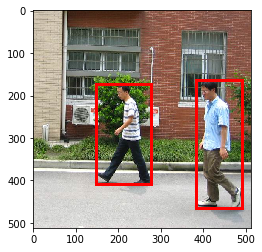

In [16]:
import numpy as np

img = batch.data[0][0].asnumpy()  # grab the first image, convert to numpy array
img = img.transpose((1, 2, 0))  # we want channel to be the last dimension
img += np.array([123, 117, 104])
img = img.astype(np.uint8)  # use uint8 (0-255)
# draw bounding boxes on image
for label in batch.label[0][0].asnumpy():
    if label[0] < 0:
        break
    print(label)
    xmin, ymin, xmax, ymax = [int(x * data_shape) for x in label[1:5]]
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=(1, 0, 0), linewidth=3)
    plt.gca().add_patch(rect)
plt.imshow(img)
plt.show()

In [19]:
#step 14
from mxnet.contrib.ndarray import MultiBoxTarget

def training_targets(default_anchors, class_predicts, labels):
    class_predicts = nd.transpose(class_predicts, axes=(0, 2, 1))
    z = MultiBoxTarget(*[default_anchors, labels, class_predicts])
    box_target = z[0]  # box offset target for (x, y, width, height)
    box_mask = z[1]  # mask is used to ignore box offsets we don't want to penalize, e.g. negative samples
    cls_target = z[2]  # cls_target is an array of labels for all anchors boxes
    return box_target, box_mask, cls_target

In [20]:
#step 15
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma

    def hybrid_forward(self, F, output, label):
        output = F.softmax(output)
        pt = F.pick(output, label, axis=self._axis, keepdims=True)
        loss = -self._alpha * ((1 - pt) ** self._gamma) * F.log(pt)
        return F.mean(loss, axis=self._batch_axis, exclude=True)

cls_loss = FocalLoss()
print(cls_loss)

FocalLoss(batch_axis=0, w=None)


In [21]:
#step 16
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)

    def hybrid_forward(self, F, output, label, mask):
        loss = F.smooth_l1((output - label) * mask, scalar=1.0)
        return F.mean(loss, self._batch_axis, exclude=True)

box_loss = SmoothL1Loss()
print(box_loss)

SmoothL1Loss(batch_axis=0, w=None)


In [22]:
#step 17
cls_metric = mx.metric.Accuracy()
box_metric = mx.metric.MAE()  # measure absolute difference between prediction and target

In [23]:
#step 18
### Set context for training
ctx = mx.cpu()  # it may takes too long to train using CPU
# try:
#     _ = nd.zeros(1, ctx=ctx)
#     # pad label for cuda implementation
#     #train_data.reshape(label_shape=(3, 5))
#     train_data = test_data.sync_label_shape(train_data)
# except mx.base.MXNetError as err:
#     print('No GPU enabled, fall back to CPU, sit back and be patient...')
#     ctx = mx.cpu()

In [24]:
#step 19
net = ToySSD(num_class)
net.initialize(mx.init.Xavier(magnitude=2), ctx=ctx)
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'wd': 5e-4})
epochs = 10         # set larger to get better performance
log_interval = 100
from_scratch = False  #False  # set to True to train from scratch
if from_scratch:
    start_epoch = 0
else:
    start_epoch = 3
    pretrained = 'my_ssd2_100.params'
    net.load_parameters(pretrained, ctx)

In [44]:
#step 20 train
import time
from mxnet import autograd as ag

print("(1)Train from scratch or (2)Load pretrained parameters?")
choice = eval(input("Please enter your choice: "))

if choice == 1:
    for epoch in range(start_epoch, epochs):
        # reset iterator and tick
        train_data.reset()
        cls_metric.reset()
        box_metric.reset()
        tic = time.time()
        # iterate through all batch
        for i, batch in enumerate(train_data):
            btic = time.time()
            # record gradients
            with ag.record():
                x = batch.data[0].as_in_context(ctx)
                y = batch.label[0].as_in_context(ctx)
                default_anchors, class_predictions, box_predictions = net(x)
                box_target, box_mask, cls_target = training_targets(default_anchors, class_predictions, y)
                # losses
                loss1 = cls_loss(class_predictions, cls_target)
                loss2 = box_loss(box_predictions, box_target, box_mask)
                # sum all losses
                loss = loss1 + loss2
                # backpropagate
                loss.backward()
            # apply
            trainer.step(batch_size)
            # update metrics
            cls_metric.update([cls_target], [nd.transpose(class_predictions, (0, 2, 1))])
            box_metric.update([box_target], [box_predictions * box_mask])
            if (i + 1) % log_interval == 0:
                name1, val1 = cls_metric.get()
                name2, val2 = box_metric.get()
                print('[Epoch %d Batch %d] speed: %f samples/s, training: %s=%f, %s=%f'
                      %(epoch ,i, batch_size/(time.time()-btic), name1, val1, name2, val2))
        # end of epoch logging
        name1, val1 = cls_metric.get()
        name2, val2 = box_metric.get()
        print('[Epoch %d] training: %s=%f, %s=%f'%(epoch, name1, val1, name2, val2))
        print('[Epoch %d] time cost: %f'%(epoch, time.time()-tic))

    # we can save the trained parameters to disk
    net.save_params('my_ssd_%d.params' % epochs)
elif choice == 2:
    pretrained = 'my_ssd_250.params'
    net.load_parameters(pretrained, ctx)

(1)Train from scratch or (2)Load pretrained parameters?
Please enter your choice: 2


In [45]:
#step 21 预测
import numpy as np
import cv2

def preprocess(image):
    """Takes an image and apply preprocess"""
    # resize to data_shape
    image = cv2.resize(image, (data_shape, data_shape))
    # swap BGR to RGB
    image = image[:, :, (2, 1, 0)]
    # convert to float before subtracting mean
    image = image.astype(np.float32)
    # subtract mean
    image -= np.array([123, 117, 104])
    # organize as [batch-channel-height-width]
    image = np.transpose(image, (2, 0, 1))
    image = image[np.newaxis, :]
    # convert to ndarray
    image = nd.array(image)
    return image

In [50]:
image = cv2.imread('D:/SourceCode/jupyter-notebook/test/test06.png')
x = preprocess(image)

print('x', x.shape)
anchors, cls_preds, box_preds = net(x.as_in_context(ctx))
# print('anchors', anchors)
# print('class predictions', cls_preds)
# print('box delta predictions', box_preds)

x (1, 3, 512, 512)


In [51]:
from mxnet.contrib.ndarray import MultiBoxDetection

# convert predictions to probabilities using softmax
cls_probs = nd.SoftmaxActivation(nd.transpose(cls_preds, (0, 2, 1)), mode='channel')
# apply shifts to anchors boxes, non-maximum-suppression, etc...
output = MultiBoxDetection(*[cls_probs, box_preds, anchors], force_suppress=True, clip=False)
#print(output)

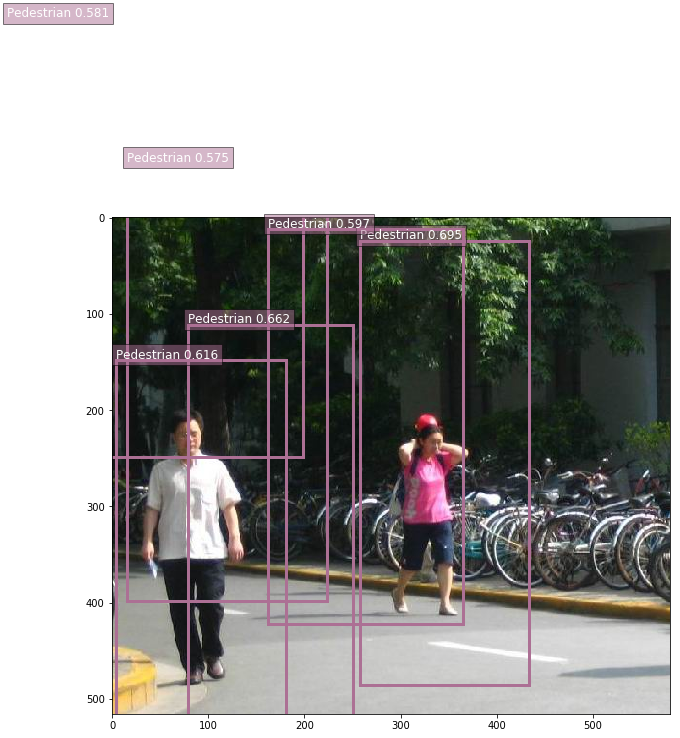

In [52]:
def display(img, out, thresh=0.5):
    import random
    import matplotlib as mpl
    mpl.rcParams['figure.figsize'] = (10,10)
    pens = dict()
    plt.clf()
    plt.imshow(img)
    for det in out:
        cid = int(det[0])
        if cid < 0:
            continue
        score = det[1]
        if score < thresh:
            continue
        if cid not in pens:
            pens[cid] = (random.random(), random.random(), random.random())
        scales = [img.shape[1], img.shape[0]] * 2
        xmin, ymin, xmax, ymax = [int(p * s) for p, s in zip(det[2:6].tolist(), scales)]
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False,
                             edgecolor=pens[cid], linewidth=3)
        plt.gca().add_patch(rect)
        text = class_names[cid]
        plt.gca().text(xmin, ymin-2, '{:s} {:.3f}'.format(text, score),
                       bbox=dict(facecolor=pens[cid], alpha=0.5),
                       fontsize=12, color='white')
    plt.show()

display(image[:, :, (2, 1, 0)], output[0].asnumpy(), thresh=0.56)